# **Overview dataset**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode

import pandas as pd
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from torch.utils.data import SequentialSampler

!pip install torchmetrics
!pip install --upgrade torchmetrics
import torchmetrics

import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 13.7 MB/s eta 0:00:00


In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda') # GPU
else:
  device = torch.device('cpu') # CPU

print(device)
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

cpu
Using 0 GPUs
CUDA is available: False


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    t_Labels = []
    t_Preds = []

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        t_Labels.extend(labels)
        t_Preds.extend(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time, t_Preds, t_Labels

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    v_Labels = []
    v_Preds = []

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

            v_Labels.extend(labels)
            v_Preds.extend(predicts)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"/content/drive/MyDrive/HW3_dataset/HW3_model.pth")

    return epoch_loss, epoch_acc, total_time, best_acc, v_Preds, v_Labels

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        state_dict = torch.load(model_path, weights_only=True) # Prevent risks with untrusted pickle data.
        model.load_state_dict(state_dict)
        #model.load_state_dict(torch.load(model_path)) # TA's code
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    e_Labels = []
    e_Preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

            e_Labels.extend(labels)
            e_Preds.extend(predicts)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc, e_Preds, e_Labels

In [5]:
# define folder path for each set
train_path = '/content/drive/MyDrive/HW3_dataset/train'
test_path = '/content/drive/MyDrive/HW3_dataset/test'
val_path = '/content/drive/MyDrive/HW3_dataset/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
sampler_tr = SequentialSampler(train_dataset) # To make sure to more control over the dataloaders order
sampler_va = SequentialSampler(val_dataset) # To make sure to more control over the dataloaders order
sampler_te = SequentialSampler(test_dataset) # To make sure to more control over the dataloaders order
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler_tr, shuffle=False) # TA's code shuffle=True
val_loader = DataLoader(val_dataset, batch_size=64, sampler=sampler_va, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, sampler=sampler_te, shuffle=False)

In [6]:
# Overview dataset
def analyze_dataset(dataloader):
  all_labels = []
  all_shapes = []
  for images, labels in dataloader:
    all_labels.extend(labels.tolist())
    for image in images:
      all_shapes.append(image.shape)

  label_counts = pd.Series(all_labels).value_counts()
  unique_shapes = set(all_shapes)

  return {
      "Number of Images": len(all_labels),
      "Number of Labels (Classes)": len(label_counts),
      "Label Counts": label_counts.to_dict(),
      "Unique Shapes": unique_shapes,
  }

train_stats = analyze_dataset(train_loader)
test_stats = analyze_dataset(test_loader)
val_stats = analyze_dataset(val_loader)

# Print the statistics for each dataset
print("Train Dataset Statistics:")
for key, value in train_stats.items():
  print(f"{key}: {value}")
print("\n")

print("Test Dataset Statistics:")
for key, value in test_stats.items():
  print(f"{key}: {value}")
print("\n")

print("Validation Dataset Statistics:")
for key, value in val_stats.items():
  print(f"{key}: {value}")

Train Dataset Statistics:
Number of Images: 2000
Number of Labels (Classes): 2
Label Counts: {0: 1000, 1: 1000}
Unique Shapes: {torch.Size([1, 256, 256])}


Test Dataset Statistics:
Number of Images: 624
Number of Labels (Classes): 2
Label Counts: {1: 390, 0: 234}
Unique Shapes: {torch.Size([1, 256, 256])}


Validation Dataset Statistics:
Number of Images: 16
Number of Labels (Classes): 2
Label Counts: {0: 8, 1: 8}
Unique Shapes: {torch.Size([1, 256, 256])}


In [7]:
# Examine classes
print("Train Dataset Labels:", train_dataset.classes)
print("Test Dataset Labels:", test_dataset.classes)
print("Validation Dataset Labels:", val_dataset.classes)

Train Dataset Labels: ['NORMAL', 'PNEUMONIA']
Test Dataset Labels: ['NORMAL', 'PNEUMONIA']
Validation Dataset Labels: ['NORMAL', 'PNEUMONIA']


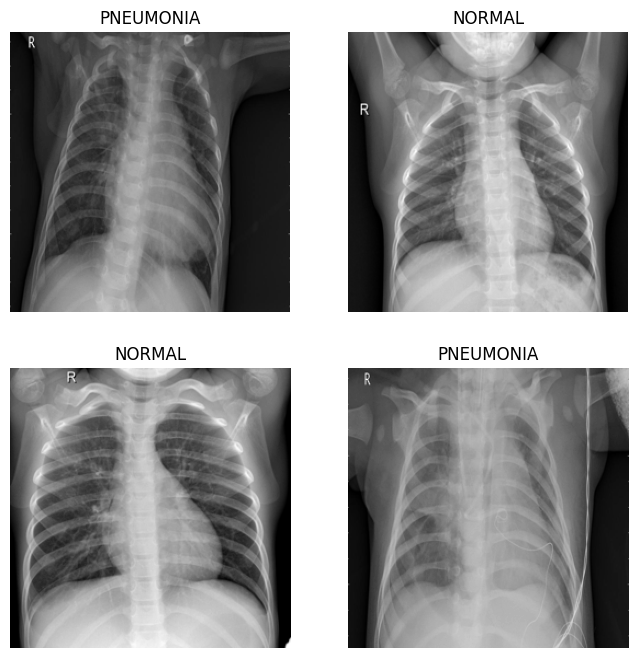

In [8]:
# Examine image quality
labels_map = {
    0: train_dataset.classes[0],
    1: train_dataset.classes[1],
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


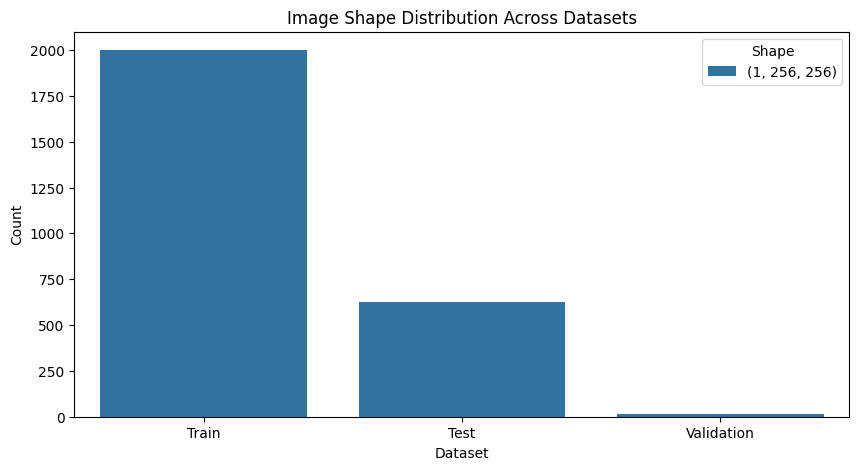

In [20]:
# Examine image shape
def get_image_shapes(dataloader):
  shapes = defaultdict(int)
  for images, labels in dataloader:
    for image in images:
      shape = tuple(image.shape)
      shapes[shape] += 1
  return shapes

train_shapes = get_image_shapes(train_loader)
test_shapes = get_image_shapes(test_loader)
val_shapes = get_image_shapes(val_loader)

# Combine the data for plotting
data = {
    'Dataset': ['Train'] * len(train_shapes) + ['Test'] * len(test_shapes) + ['Validation'] * len(val_shapes),
    'Shape': list(train_shapes.keys()) + list(test_shapes.keys()) + list(val_shapes.keys()),
    'Count': list(train_shapes.values()) + list(test_shapes.values()) + list(val_shapes.values())
}
df = pd.DataFrame(data)

# Convert shapes to strings for plotting
df['Shape'] = df['Shape'].astype(str)

# Create the plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Dataset', y='Count', hue='Shape', data=df) # Removed extra parentheses from hue
plt.title('Image Shape Distribution Across Datasets')
plt.show()

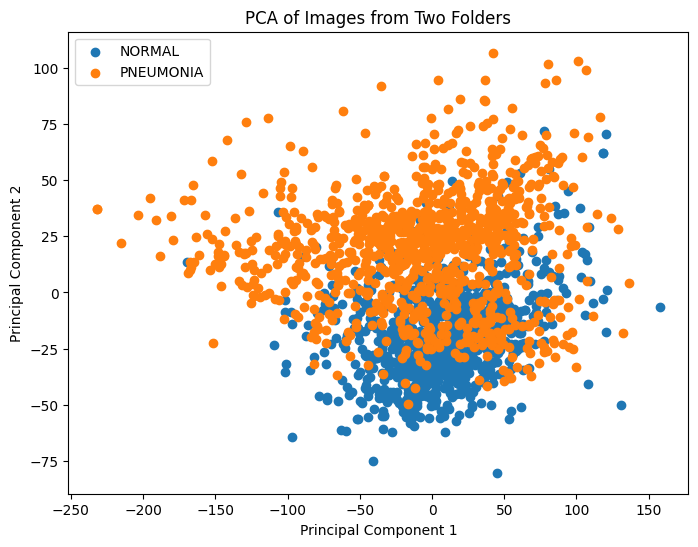

In [10]:
# PCA analysis
# Folder paths containing images
folder_path_NORMAL = '/content/drive/MyDrive/HW3_dataset/train/NORMAL'
folder_path_PNEUMONIA = '/content/drive/MyDrive/HW3_dataset/train/PNEUMONIA'

# Load images, resize and flatten
images = []
labels = []
for folder_path in [folder_path_NORMAL, folder_path_PNEUMONIA]:
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(folder_path, filename)).convert('L')
            img = img.resize((100, 100))
            img_array = np.array(img)
            flattened_img = img_array.flatten()
            images.append(flattened_img)
            labels.append(os.path.basename(folder_path)) # Use folder name as label

images = np.array(images)

# Standardize the data
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images)

# Apply PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_images)

# Visualize the data
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(principal_components[indices, 0], principal_components[indices, 1], label=label)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Images from Two Folders')
plt.legend()
plt.show()

# **Model**

In [11]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #nn.Dropout(0.5), # TA defult with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #nn.Dropout(0.5), # TA defult with dropout p=0.5

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    #nn.Dropout(0.5), # TA defult with dropout p=0.5

    nn.Linear(64, 1),
    nn.Sigmoid()
)

model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=64, bias=True)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=1, bias=True)
  (11): Sigmoid()
)


In [12]:
# Load DOE table
doe02 = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/HW3_dataset/HW3_DOE_02.CSV'))
doe02.head()

,StdOrder,RunOrder,CenterPt,Blocks,lr,weight_decay,factor,criterion
0,8,1,1,1,0.0010,0.0010,0.10,nn.MSELoss()
1,2,2,1,1,0.0010,0.0001,0.01,nn.MSELoss()
2,16,3,1,1,0.0010,0.0010,0.10,nn.BCELoss()
3,6,4,1,1,0.0010,0.0001,0.10,nn.MSELoss()
4,13,5,1,1,0.0001,0.0001,0.10,nn.BCELoss()


In [13]:
# define the weight_init function and make sure the same weights every time
def weight_init(m):
    if isinstance(m, nn.Linear):
        torch.manual_seed(42)  # Set the seed for CPU
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42)  # Set the seed for CUDA
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [14]:
# DOE FFD with 4 independent varaible and 1 block
summary = pd.DataFrame([])

for i in range(len(doe02)):
  lr = doe02.iloc[i,4]
  weight_decay = doe02.iloc[i,5]
  factor = doe02.iloc[i,6]

  # criterion
  if doe02.iloc[i,7] == 'nn.MSELoss()':
    criterion = nn.MSELoss()
  elif doe02.iloc[i,7] == 'nn.BCELoss()':
    criterion = nn.BCELoss()

  optimizer = optims.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
  lr_scheduler = optims.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=3, mode='max') # TA's patience=5
  epochs = 10 # TA set defult epochs to 10

  # save checkpoint
  save = 'model'

  # Initial for training
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  best_acc = 0.0
  output_list = []

  # Initial weight with your_seed to keep the same random weights for each initialization
  model.apply(weight_init)

  # Training loop
  for epoch in range(epochs):
    train_loss, train_acc, train_time, train_p, train_l = train_one_epoch(model, device, criterion, optimizer, train_loader)
    val_loss, val_acc, val_time, best_acc, val_p, val_l = val_one_epoch(model, device, criterion, val_loader, best_acc, save)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    total_time = train_time + val_time
    output_str = f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - train_acc: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_acc: {val_acc:.2f}% - time: {total_time:.2f}s"
    output_list.append(output_str)

    summary = pd.concat([summary, pd.DataFrame({
        "RunOrder": ['DOE RunOrder ' + str(i+1)],
        "Epoch": [epoch+1],
        "Train Loss": [train_loss],
        "Train Accuracy": [train_acc],
        "Val Loss": [val_loss],
        "Val Accuracy": [val_acc],
        "Total Time": [total_time],
        })])

    print('DOE RunOrder ' + str(i+1) , output_str)
    lr_scheduler.step(val_acc)

  # Graph
  plt.figure(figsize=(12, 5))

  # loss graph
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('DOE RunOrder ' + str(i+1) + ' Loss Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # accuracy graph
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.title('DOE RunOrder ' + str(i+1) + ' Accuracy Curve')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  # show
  plt.tight_layout()
  plt.show()

  # Evalute
  model_path = 'model.pth'
  avg_test_loss, avg_test_acc, eva_p, eva_l = evaluate(model, device, model_path, test_loader)

  # Plot precision-recall curve
  pr_curve = torchmetrics.PrecisionRecallCurve(task='binary')

  # Convert to tensors if they are lists
  train_p = torch.tensor(train_p) if isinstance(train_p, list) else train_p
  train_l = torch.tensor(train_l) if isinstance(train_l, list) else train_l
  val_p = torch.tensor(val_p) if isinstance(val_p, list) else val_p
  val_l = torch.tensor(val_l) if isinstance(val_l, list) else val_l
  eva_p = torch.tensor(eva_p) if isinstance(eva_p, list) else eva_p
  eva_l = torch.tensor(eva_l) if isinstance(eva_l, list) else eva_l

  # Convert to float32
  train_p = train_p.clone().detach() # Use clone and detach to create a copy of the tensor
  train_l = train_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
  val_p = val_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
  val_l = val_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long
  eva_p = eva_p.clone().detach()  # Use clone().detach() to avoid unintended memory sharing
  eva_l = eva_l.clone().detach().long() # Use clone and detach to create a copy of the tensor and convert to long

  precision_v, recall_v, thresholds_v = pr_curve(val_p, val_l)
  plt.figure()
  plt.step(recall_v, precision_v, where='post')
  plt.fill_between(recall_v, precision_v, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('DOE RunOrder ' + str(i+1) + ' Val PR curve')
  plt.show()

  precision_e, recall_e, thresholds_e = pr_curve(eva_p, eva_l)
  plt.figure()
  plt.step(recall_e, precision_e, where='post')
  plt.fill_between(recall_e, precision_e, step='post', alpha=0.2, color='b')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('DOE RunOrder ' + str(i+1) + ' Evaluate PR curve')
  plt.show()

summary.to_excel('/content/drive/MyDrive/HW3_dataset/DOE_summary.xlsx')

DOE RunOrder 1 Epoch 1/10 - loss: 0.3001 - train_acc: 42.29% - val_loss: 0.2679 - val_acc: 56.25% - time: 80.83s


KeyboardInterrupt: 